# EM 算法实现混合高斯模型

高斯混合模型原理：<br>
1.使用训练数据符合多元高斯分布，输入维度[N,D]<br>

2.高斯混合模型的目标函数:<br>
 $$L =\sum_{n=1}^{N} \log \sum_{k=1}^{K} \pi_{k} p\left(\boldsymbol{x}_{n} | \boldsymbol{\mu}_{k}, \boldsymbol{\Sigma}_{k}\right)$$
 
3.两边取对数求最值。为了实现log(sum(f(x)))形态的函数计算，引入了新的参数q_{nk},使得原式变为：
$$L = \sum_{n=1}^{N} \log \mathbf{E}_{q_{n k}}\left\{\frac{\pi_{k} p\left(\boldsymbol{x}_{n} | \boldsymbol{\mu}_{k}, \boldsymbol{\Sigma}_{k}\right)}{q_{n k}}\right\}$$
满足了Jensen不等式条件：$$\log E_{p(z)}\{f(z)\} \geq E_{p(z)}\{\log f(z)\}$$

4.原问题变为优化L的下界，使得L的下界最大。未知参数为{$q_{n k}$,$\boldsymbol{\mu}_{k}$,$\boldsymbol{\Sigma}_{k}$,$\pi_{k}$}

5.经过求偏导得到它们的更新公式：
$$\pi_{k}=\frac{1}{N} \sum_{n=1}^{N} q_{n k}$$
$$\mu_{k}=\frac{\sum_{n=1}^{N} q_{n k} \boldsymbol{x}_{n}}{\sum_{n=1}^{N} q_{n k}}$$
$$\mathbf{\Sigma}_{k}=\frac{\sum_{n=1}^{N} q_{n k}\left(\boldsymbol{x}_{n}-\boldsymbol{\mu}_{k}\right)\left(\boldsymbol{x}_{n}-\boldsymbol{\mu}_{k}\right)^{t}}{\sum_{n=1}^{N} q_{n k}}$$
$$q_{n k}=\frac{\pi_{k} p\left(\boldsymbol{x}_{n} | \boldsymbol{\mu}_{k}, \boldsymbol{\Sigma}_{k}\right)}{\sum_{j=1}^{K} \pi_{j} p\left(\boldsymbol{x}_{n} | \boldsymbol{\mu}_{j}, \boldsymbol{\Sigma}_{j}\right)}$$
$$\sum_{k}^{K} \pi_{k}=1$$

Expactation-Maximization (EM算法)：
用来求解这些参数。因为参数之间相互依赖，EM算法先通过先验概率来估计一个后验概率$q_{n k}$。再根据这个后验概率来更新先验概率，进行交替迭代，最后使得参数基于稳定。L值趋于不变。


In [2]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import time
%matplotlib inline

In [86]:
class MixtureGaussian():
    def __init__(self,K):
        #初始化k高斯函数的数目,mu均值,sigma协方差
        self.K = K
        self.sigma = None
        self.mu = None
    def param_init(self,X,seed_num):
        '''
        param_init 参数赋初值:
        1.sigma是input数据的协方差
        2.mu为随机选取的k个数据点
        3.pi为和为1的k个参数
        '''
        m,n = X.shape
        self.pi = np.ones(self.K) / self.K
        self.mu = X[[np.random.randint(m) for _ in range(self.K)]]
        self.sigma = [ ((X - self.mu[k]).T @ (X - self.mu[k])) / m for k in range(self.K)]
        
    
    def cal_gaussian(self,X,mu,sigma):
        '''
        计算多元高斯也就是条件概率的值
        X:[batch_size,d]
        mu:[1,d]
        sigma:[d,d]
        '''
        m = X.shape[0]
        X = X[:,None]
        mu = mu[:,None]
        #print(X.shape,mu.shape,sigma.shape)
        gauss = np.exp(-0.5*((X-mu).T@np.linalg.inv(sigma)*(X-mu)).sum()/np.sqrt((2*np.pi) ** m * np.linalg.det(sigma)))
        #print(gauss.shape)
        return gauss
                      
    def E_step(self,X):
        '''
        计算后验概率q
        '''
        m,n = X.shape
        #print(m,n)
        q = np.zeros((m,self.K))
        loss = 0
        for i in range(m):
            sum1 = np.sum(self.pi[k] * self.cal_gaussian(X[i],self.mu[k],self.sigma[k]) for k in range(self.K))
            for j in range(self.K):
                q[i,j] = (self.pi[j] * self.cal_gaussian(X[i],self.mu[j],self.sigma[j])/sum1)
            loss += np.log(sum1)
        return q,loss
    def M_step(self,X,q):
        m,n = X.shape 
        sumq = np.sum(q,axis = 0)
        self.pi = sumq / m
        self.mu = q.T @ X / sumq
        #print(sumq.shape,q.shape)
        self.sigma = [(q[:,k][:,None] * (X-self.mu[k])).T @ (X-self.mu[k]) / sumq[k] for k in range(self.K)]
        
    def train(self,X,iterations):
        self.param_init(X,2000)
        for iter in range(iterations):
            q,loss = self.E_step(X)
            self.M_step(X,q)
        return loss
    
    def predict(self,X):
        y = []
        for x in X:
            y.append(np.argmax([self.cal_gaussian(x,self.mu[k],self.sigma[k]) for k in range(self.K)]))
        return y
            
            
        
                
        
        
        
        

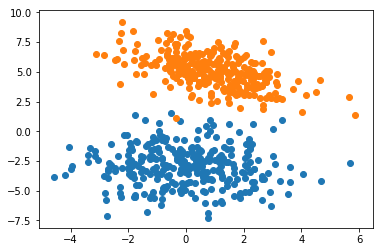

In [24]:
#Create new data
m1 = np.array([0,-3])
m2 = np.array([1,5])
C1 = np.array([[3,0],[0,3]]) #协方差矩阵要求为正定矩阵
C2 = np.array([[2,-1],[-1,2]])
m = 300
X1 = np.random.randn(m,2)
X2 = np.random.randn(m,2)
A1 = np.linalg.cholesky(C1)
A2 = np.linalg.cholesky(C2)
X1 = X1 @ A1.T + m1
X2 = X2 @ A2.T + m2
X = np.concatenate([X1, X2], axis=0)
plt.scatter(X1[:,0], X1[:,1])
plt.scatter(X2[:,0], X2[:,1])

In [79]:
x = np.array([0, 1, 2])
x[:, np.newaxis].shape

(3, 1)

In [ ]:
model = MixtureGaussian(K=2)
model.train(X,100)
y = model.predict(X)


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:44: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


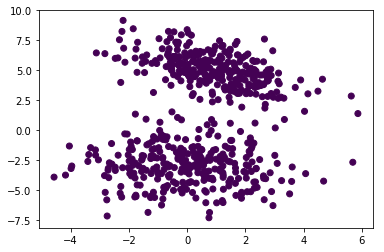

In [84]:
plt.scatter(X[:, 0], X[:, 1], c=y)